# Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Reading data

In [ ]:
df = pd.read_excel('/content/ISEP Sexist Data labeling.xlsx')

In [ ]:
df.info()
df['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentences  1137 non-null   object
 1   Label      1137 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.9+ KB


1    624
0    513
Name: Label, dtype: int64

# Data Preprocessing

In [ ]:
def data_processing(Sentence):
    Sentence = Sentence.lower()
    Sentence = re.sub(r'[^\w\s]','',Sentence)
    Sentence = re.sub(r'\@w+|\#','', Sentence)
    Sentence = re.sub(r'ð','',Sentence)
    Sentence_tokens = word_tokenize(Sentence)
    filtered_Sentences = [w for w in Sentence_tokens if not w in stop_words]
    return " ".join(filtered_Sentences)

lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    Sentences = [lemmatizer.lemmatize(word) for word in data]
    return data

In [ ]:
df.Sentences = df['Sentences'].apply(data_processing)
df = df.drop_duplicates('Sentences')
df['Sentences'] = df['Sentences'].apply(lambda x: lemmatizing(x))

In [ ]:
# For balancing the labels
from sklearn.utils import resample
train_majority = df[df.Label==0]
train_minority = df[df.Label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
df = pd.concat([train_minority_upsampled, train_majority])
df['Label'].value_counts()


1    512
0    512
Name: Label, dtype: int64

# Data visulization

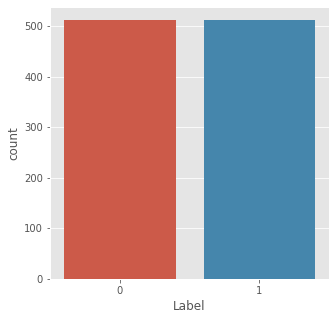

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='Label', data = df)

Text(0.5, 1.0, 'Distribution of sentiments')

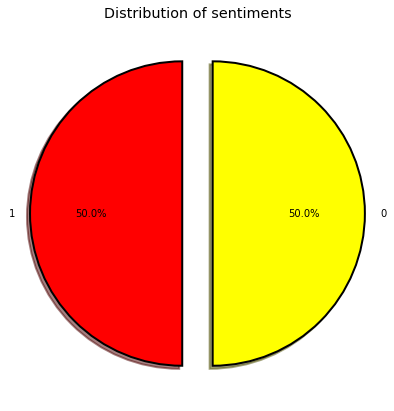

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "yellow")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['Label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

# Vectorization

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(df['Sentences'])
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))

Number of features: 10161



# Model Training & Testing

Test accuarcy: 85.37%
[[92 15]
 [15 83]] 

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       107
           1       0.85      0.85      0.85        98

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205



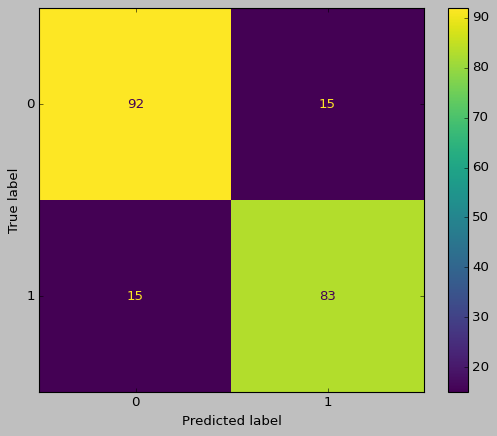

In [ ]:
X = df['Sentences']
Y = df['Label']
X = vect.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1000)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

print(confusion_matrix(y_test, logreg_predict),"\n")
print(classification_report(y_test, logreg_predict))

style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 20)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.85
Best parameters:  {'C': 100, 'solver': 'liblinear'}


In [ ]:
y_pred = grid.predict(x_test)

Test accuracy: 87.80%
[[96 11]
 [14 84]] 

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       107
           1       0.88      0.86      0.87        98

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205



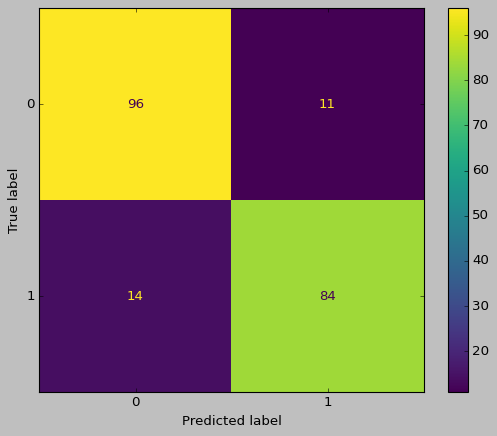

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

print(confusion_matrix(y_test, y_pred),"\n")
print(classification_report(y_test, y_pred))

style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()